In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

In [2]:
df.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'head_time', 'head_height', 'head_progress',
       'machine_duration_s', 'error', 'version', 'compute_weakest',
       'compute_strongest', 'compute_gini', 'activations_weakest',
       'activations_strongest', 'activations_gini', 'reward_weakest',
       'reward_strongest', 'reward_gini', 'efficiency_weakest',
       'efficiency_strongest', 'efficiency_gini',
       'activations_compute_gini_delta', 'reward_activations_gini_delta'],
      dtype='object')

## Protocol Implementations Checks

We have two implementations of the tailstorm protocol. They seem to produce differenct results. Let's first checks that what should be the same is the same.

### Progress

In [3]:
d = df.query('protocol in ["tailstormll", "tailstorm"]')

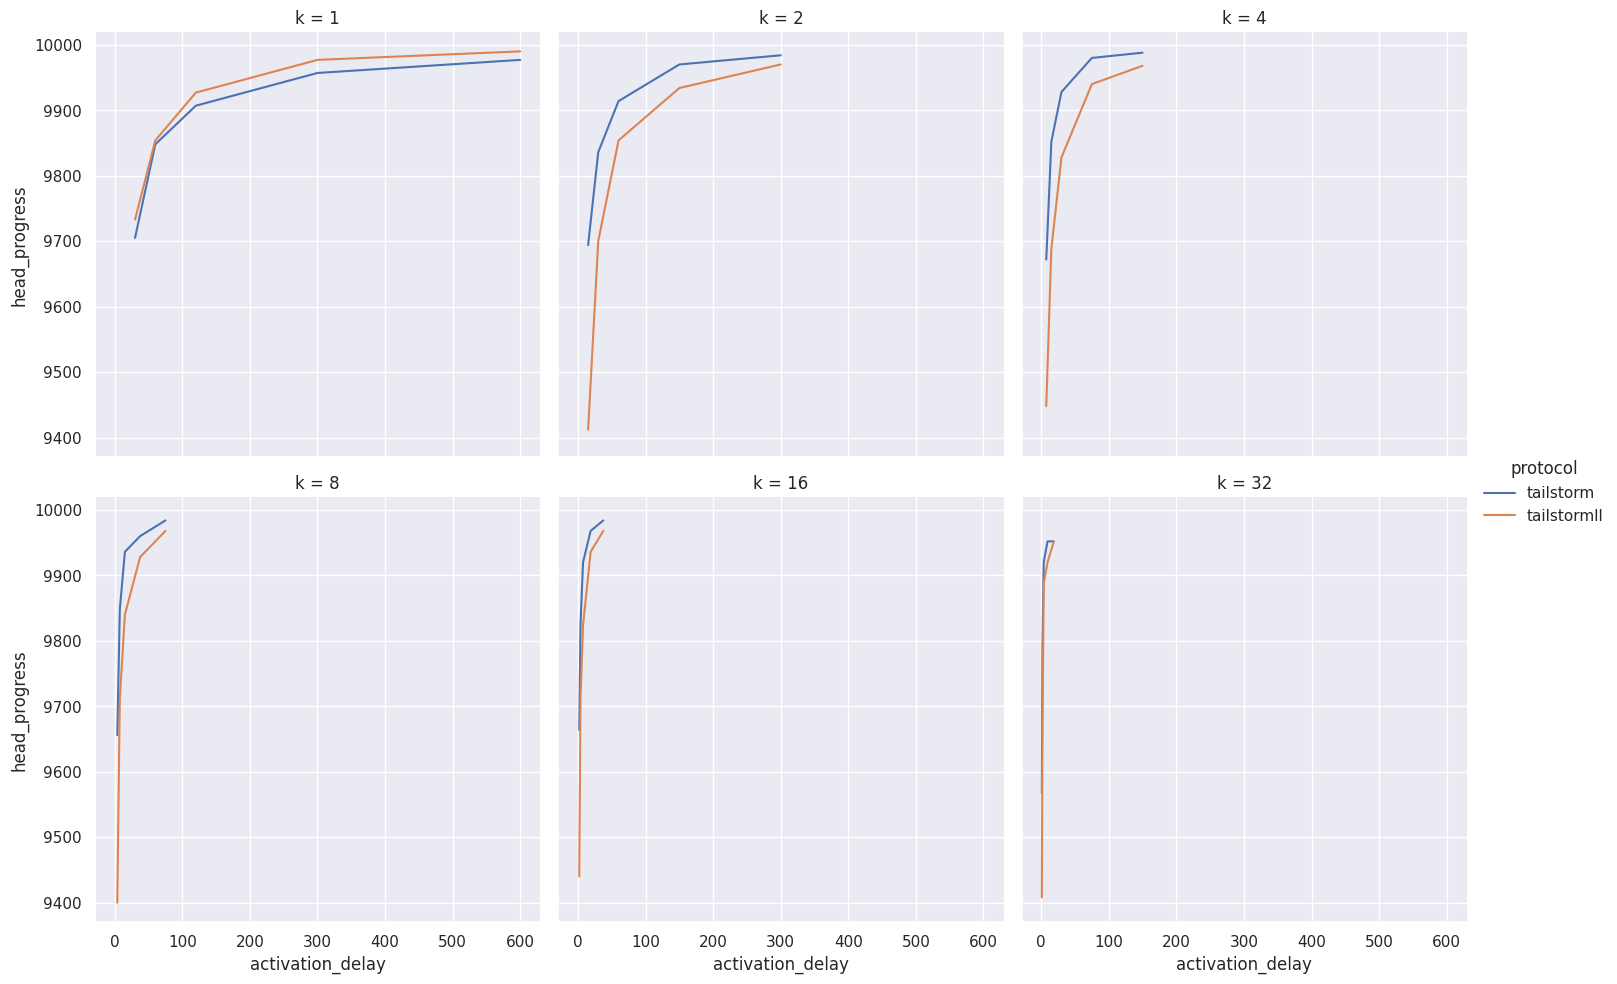

In [4]:
sns.relplot(
    data=d.query('incentive_scheme == "discount"'),
    x="activation_delay",
    y="head_progress",
    col="k",
    col_wrap=3,
    hue="protocol",
    kind="line",
)

## Incentive Schemes for Georges  Protocol

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

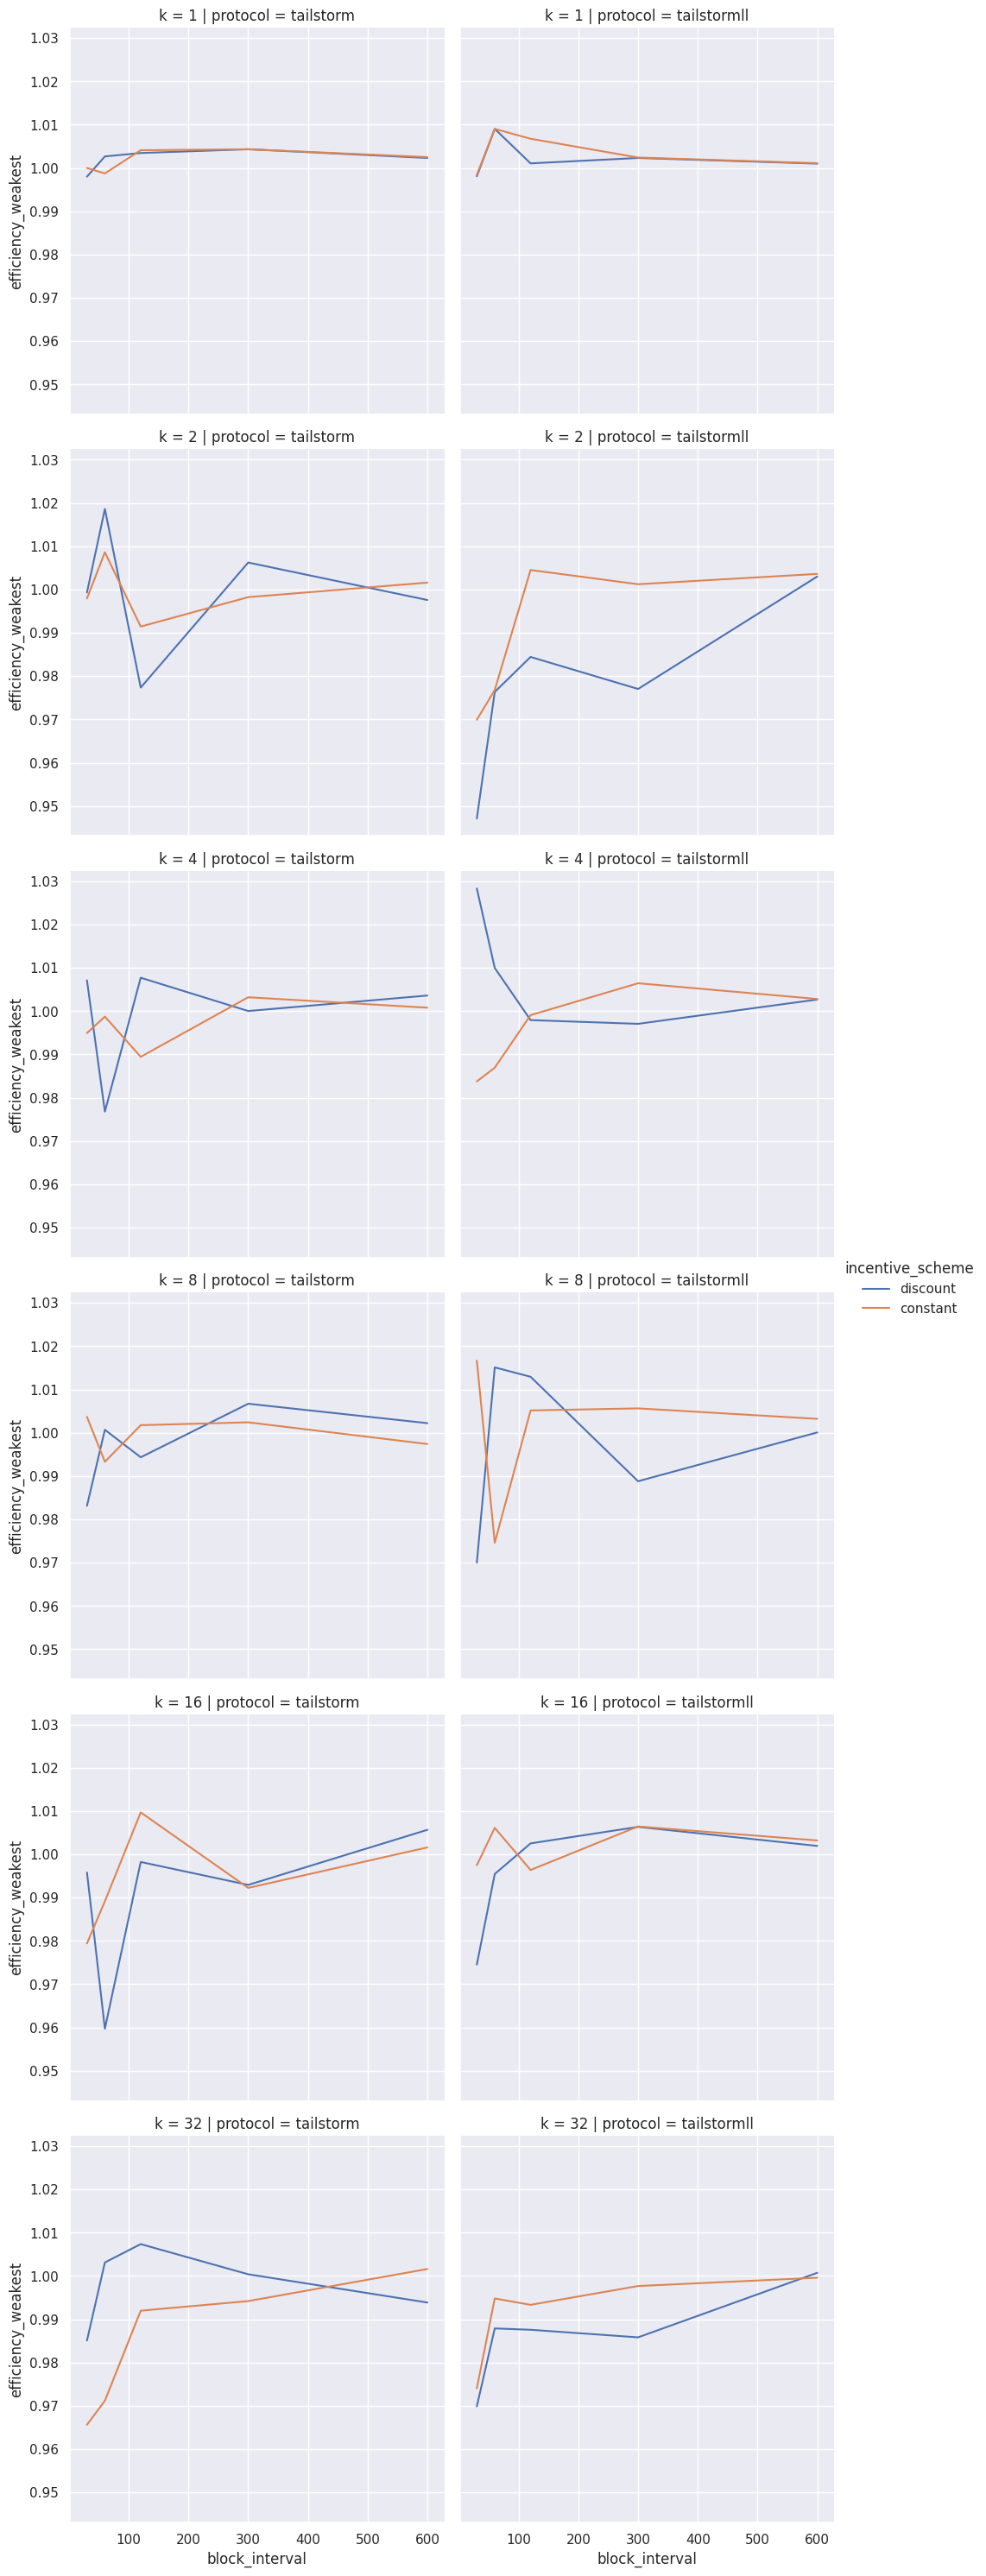

In [5]:
sns.relplot(
    data=d.query('incentive_scheme in ["constant", "discount"]'),
    x="block_interval",
    y="efficiency_weakest",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [6]:
eff = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.style.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  0.999988  0.997994  1.000142   
                  tailstormll  1.005801  0.998409  0.998077  0.991009   
               2  tailstorm         NaN  0.997950  0.999320  0.993766   
                  tailstormll  1.001384  0.969923  0.947119  0.975330   
               4  tailstorm         NaN  0.994930  1.007105  0.985188   
                  tailstormll  0.893947  0.983768  1.028338  0.981590   
               8  tailstorm         NaN  1.003662  0.983125  0.856761   
                  tailstormll  1.139731  1.016650  0.970009  0.956218   
               16 tailstorm         NaN  0.979433  0.995814  0.904414   
                  tailstormll  0.956089  0.997489  0.974535  0.938030   
               32 tailstorm         NaN  0.965628  0.985083  0.745291   
                  tailstormll  0.895095  0.974046  0.969885  0.783983   
60.0           1  tailstorm         NaN  0.998732  1.002662  0.992164   
                  tailstormll  0.992155  1.009017  1.009017  0.985910   
               2  tailstorm         NaN  1.008607  1.018612  1.019302   
                  tailstormll  1.030291  0.976798  0.976349  0.991721   
               4  tailstorm         NaN  0.998738  0.976794  1.012570   
                  tailstormll  1.079878  0.986934  1.009976  1.001830   
               8  tailstorm         NaN  0.993294  1.000684  0.951328   
                  tailstormll  1.294678  0.974592  1.015099  0.966325   
               16 tailstorm         NaN  0.989161  0.959731  0.956279   
                  tailstormll  0.867077  1.006119  0.995459  0.931722   
               32 tailstorm         NaN  0.971174  1.003116  0.938872   
                  tailstormll  0.611172  0.994801  0.987879  0.965103   
120.0          1  tailstorm         NaN  1.004093  1.003450  0.991162   
                  tailstormll  1.006745  1.006745  1.001058  1.001392   
               2  tailstorm         NaN  0.991448  0.977355  1.010909   
                  tailstormll  0.835958  1.004516  0.984433  0.999550   
               4  tailstorm         NaN  0.989448  1.007720  0.974139   
                  tailstormll  0.948124  0.999080  0.997929  1.013329   
               8  tailstorm         NaN  1.001748  0.994333  0.970835   
                  tailstormll  1.031427  1.005153  1.012929  0.940664   
               16 tailstorm         NaN  1.009693  0.998239  0.965010   
                  tailstormll  0.989864  0.996384  1.002532  0.984869   
               32 tailstorm         NaN  0.991978  1.007355  0.944830   
                  tailstormll  0.810281  0.993328  0.987566  0.985426   
300.0          1  tailstorm         NaN  1.004319  1.004319  1.003512   
                  tailstormll  1.002406  1.002406  1.002305  1.002205   
               2  tailstorm         NaN  0.998246  1.006239  0.998921   
                  tailstormll  0.924336  1.001228  0.977037  1.007049   
               4  tailstorm         NaN  1.003210  1.000031  1.004819   
                  tailstormll  0.869735  1.006441  0.997072  1.000273   
               8  tailstorm         NaN  1.002406  1.006701  1.011009   
                  tailstormll  1.091190  1.005632  0.988796  0.982203   
               16 tailstorm         NaN  0.992246  0.992940  0.977055   
                  tailstormll  0.688901  1.006441  1.006341  0.999279   
               32 tailstorm         NaN  0.994190  1.000386  0.974344   
                  tailstormll  0.366569  0.997672  0.985819  1.025443   
600.0          1  tailstorm         NaN  1.002506  1.002305  1.001703   
                  tailstormll  1.001502  1.001101  1.001001  1.001001   
               2  tailstorm         NaN  1.001603  0.997585  1.001294   
                  tailstormll  1.026953  1.003613  1.003009  0.991123   
               4  tailstorm         NaN  1.000801  1.00360

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [7]:
d.compute_gini.unique()

array([0.3])

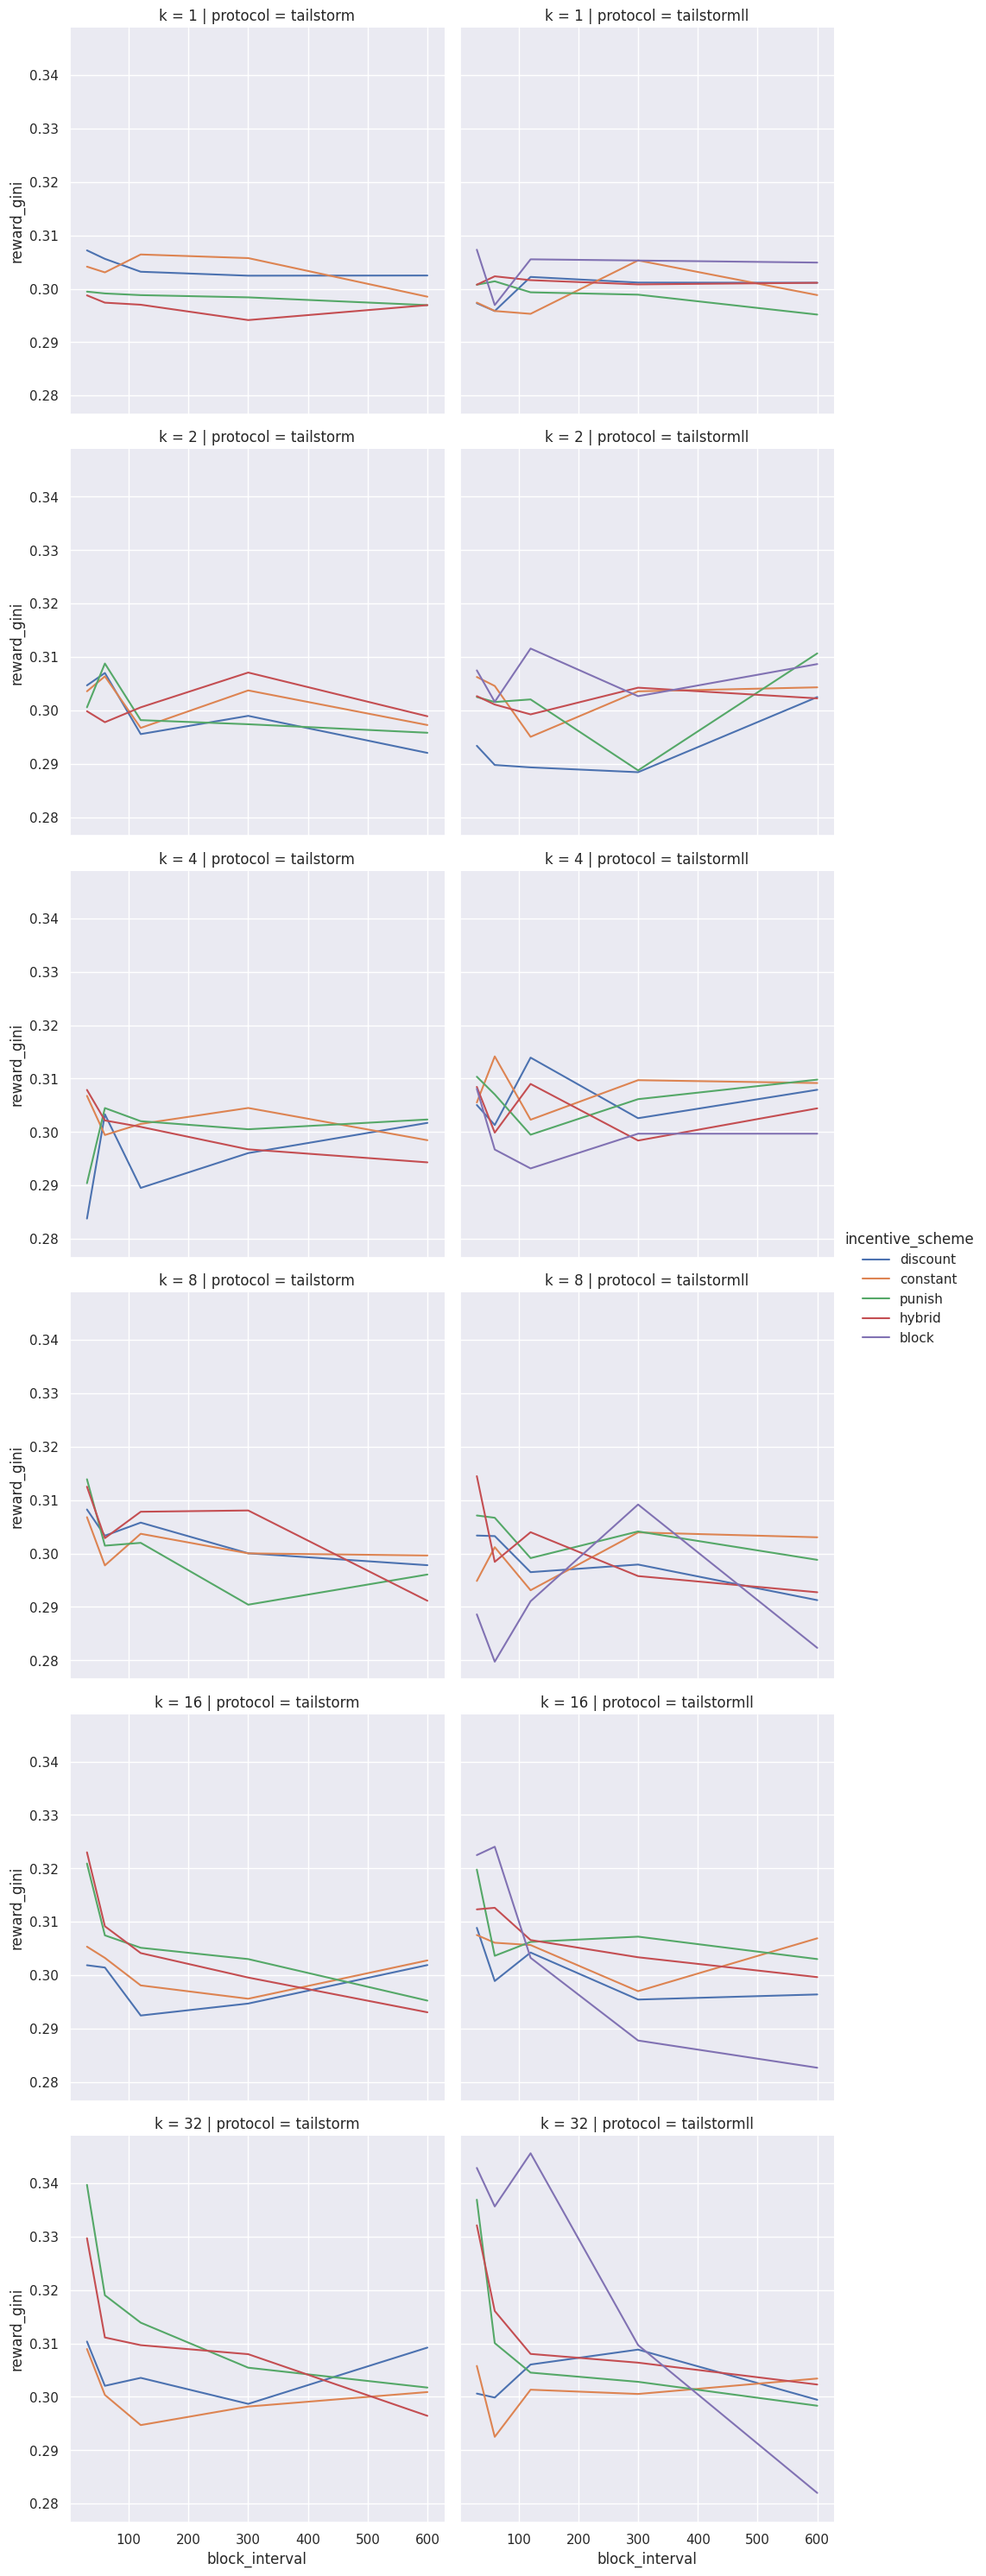

In [8]:
sns.relplot(
    data=d,
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

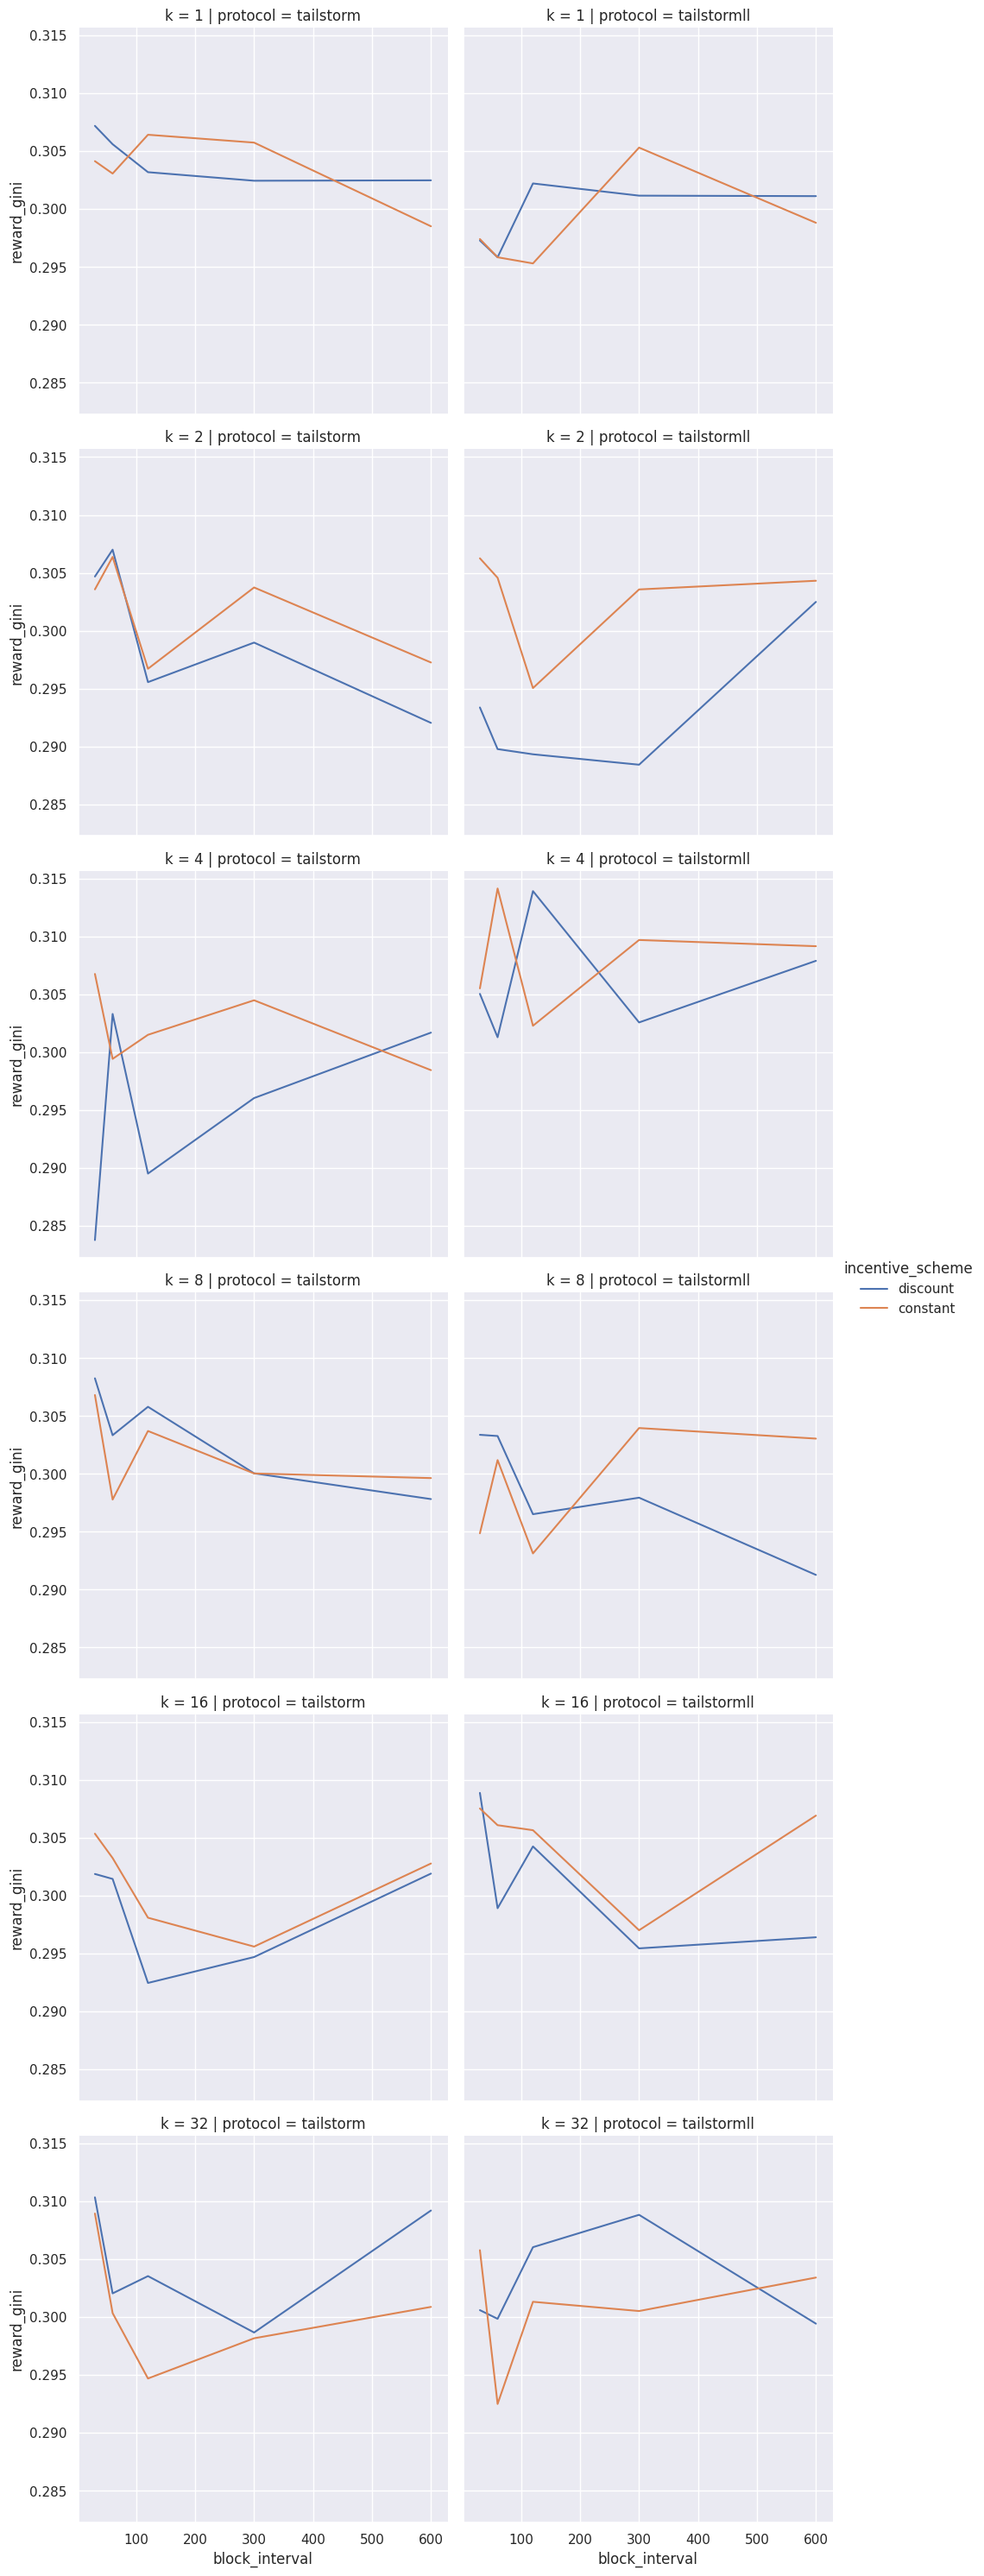

In [9]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [10]:
gini = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.style.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  0.304142  0.307192  0.298763   
                  tailstormll  0.307314  0.297411  0.297288  0.300762   
               2  tailstorm         NaN  0.303570  0.304680  0.299838   
                  tailstormll  0.307494  0.306254  0.293370  0.302667   
               4  tailstorm         NaN  0.306768  0.283779  0.307879   
                  tailstormll  0.308078  0.305523  0.305049  0.308448   
               8  tailstorm         NaN  0.306814  0.308258  0.312520   
                  tailstormll  0.288615  0.294869  0.303378  0.314500   
               16 tailstorm         NaN  0.305339  0.301860  0.323009   
                  tailstormll  0.322487  0.307517  0.308866  0.312321   
               32 tailstorm         NaN  0.308946  0.310346  0.329699   
                  tailstormll  0.342857  0.305781  0.300601  0.332108   
60.0           1  tailstorm         NaN  0.303070  0.305605  0.297398   
                  tailstormll  0.296954  0.295839  0.295839  0.302333   
               2  tailstorm         NaN  0.306372  0.307001  0.297784   
                  tailstormll  0.301607  0.304574  0.289773  0.301092   
               4  tailstorm         NaN  0.299431  0.303313  0.302161   
                  tailstormll  0.296711  0.314153  0.301301  0.299876   
               8  tailstorm         NaN  0.297785  0.303342  0.302889   
                  tailstormll  0.279753  0.301194  0.303273  0.298450   
               16 tailstorm         NaN  0.303237  0.301432  0.309158   
                  tailstormll  0.324053  0.306075  0.298902  0.312617   
               32 tailstorm         NaN  0.300346  0.302049  0.311106   
                  tailstormll  0.335644  0.292496  0.299851  0.316062   
120.0          1  tailstorm         NaN  0.306424  0.303190  0.297013   
                  tailstormll  0.305517  0.295309  0.302216  0.301611   
               2  tailstorm         NaN  0.296714  0.295557  0.300571   
                  tailstormll  0.311581  0.295045  0.289324  0.299248   
               4  tailstorm         NaN  0.301511  0.289525  0.300956   
                  tailstormll  0.293174  0.302294  0.313926  0.308995   
               8  tailstorm         NaN  0.303707  0.305797  0.307834   
                  tailstormll  0.291071  0.293130  0.296520  0.304001   
               16 tailstorm         NaN  0.298082  0.292446  0.304137   
                  tailstormll  0.303247  0.305641  0.304239  0.306576   
               32 tailstorm         NaN  0.294698  0.303542  0.309665   
                  tailstormll  0.345603  0.301323  0.306039  0.308025   
300.0          1  tailstorm         NaN  0.305745  0.302451  0.294139   
                  tailstormll  0.305293  0.305313  0.301163  0.300822   
               2  tailstorm         NaN  0.303735  0.298974  0.307083   
                  tailstormll  0.302656  0.303565  0.288424  0.304250   
               4  tailstorm         NaN  0.304494  0.296047  0.296748   
                  tailstormll  0.299678  0.309702  0.302581  0.298395   
               8  tailstorm         NaN  0.300040  0.300051  0.308072   
                  tailstormll  0.309186  0.303962  0.297946  0.295786   
               16 tailstorm         NaN  0.295586  0.294685  0.299555   
                  tailstormll  0.287762  0.297001  0.295433  0.303352   
               32 tailstorm         NaN  0.298171  0.298670  0.307977   
                  tailstormll  0.309677  0.300524  0.308835  0.306387   
600.0          1  tailstorm         NaN  0.298516  0.302486  0.296935   
                  tailstormll  0.304907  0.298819  0.301121  0.301121   
               2  tailstorm         NaN  0.297256  0.292038  0.298895   
                  tailstormll  0.308671  0.304316  0.302487  0.302247   
               4  tailstorm         NaN  0.298459  0.30170